# Model comparison
Natalia Vélez, March 2022

In this notebook, we plot model evidences/posterior probabilities/protected exceedance probabilities, model/parameter recovery results, and some qualitative checks.

In [1]:
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns
import teaching_models as teach
from os.path import join as opj
from scipy.spatial import distance
from ast import literal_eval

sys.path.append('..')
from utils import read_json, gsearch, str_extract, int_extract, print_list

sns.set_style('white')
sns.set_context('talk')

Loading teaching problems
{'A': [[0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0]],
 'B': [[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'C': [[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'D': [[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]]}
Participants excluded from analysis:
[3, 17]
Cleaning up human behavioral data
    subject  run  block_idx  ex_idx first_movement   start  problem  \
0         1    1          0       0         [0, 1]  [0, 0]       22   
1         1    1          0       1         [0, 1]  [0, 0]       22   
3         1    1          1   

## Model recovery

Find model recovery files:

In [2]:
model_files = gsearch('outputs/simulated_model_comparison/*pxp.txt')
model_files.sort()
print_list(model_files)

Found 11 items
outputs/simulated_model_comparison/model-cost_pxp.txt
outputs/simulated_model_comparison/model-literal_cost_pxp.txt
outputs/simulated_model_comparison/model-literal_pref_cost_pxp.txt
outputs/simulated_model_comparison/model-literal_pref_pxp.txt
outputs/simulated_model_comparison/model-literal_pxp.txt
outputs/simulated_model_comparison/model-pragmatic_cost_pxp.txt
outputs/simulated_model_comparison/model-pragmatic_pref_cost_pxp.txt
outputs/simulated_model_comparison/model-pragmatic_pref_pxp.txt
outputs/simulated_model_comparison/model-pragmatic_pxp.txt
outputs/simulated_model_comparison/model-pref_cost_pxp.txt
...


Data wrangling

In [3]:
pxp_list = []
model_levels = ['pragmatic_pref_cost',  'pragmatic_pref',  'pragmatic_cost', 'pragmatic', 'literal_pref_cost', 'literal_pref',  'literal_cost', 'literal', 'pref_cost',  'pref', 'cost']
for f in model_files:
    pxp = np.loadtxt(f,delimiter=',')

    label_f = f.replace('pxp', 'model_labels')
    labels = np.loadtxt(label_f, dtype=str)

    f_df = pd.DataFrame(list(zip(labels, pxp)), columns=['fit_model', 'pxp'])
    f_df['true_model'] = str_extract('(?<=model-).+(?=_pxp)', f)
    
    pxp_list.append(f_df)
    
pxp_df = pd.concat(pxp_list)
pxp_df['fit_model'] = pxp_df.fit_model.astype('category').cat.reorder_categories(model_levels)
pxp_df['true_model'] = pxp_df.true_model.astype('category').cat.reorder_categories(model_levels)

print(pxp_df.shape)
pxp_df.head()

(121, 3)


,fit_model,pxp,true_model
0,cost,1.000000e+00,cost
1,literal,7.349649e-17,cost
2,literal_cost,7.349649e-17,cost
3,literal_pref,7.349649e-17,cost
4,literal_pref_cost,7.349649e-17,cost


Make confusion matrix

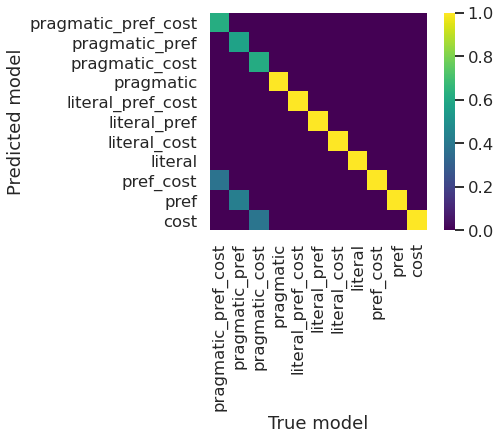

In [4]:
confusion_mtx = pxp_df.pivot(index='fit_model', columns='true_model', values='pxp')
ax = sns.heatmap(confusion_mtx, cmap='viridis', square=True)
ax.set(xlabel='True model', ylabel='Predicted model')
plt.savefig('plots/model_recovery.png', bbox_inches='tight')

## Parameter recovery

Find best-fitting parameters:

In [5]:
param_files = gsearch('outputs', 'fit_model-*_pref_cost_method-optimize', '*result.json')
param_files.sort()
print_list(param_files)

Found 56 items
outputs/fit_model-literal_pref_cost_method-optimize/sub-01_model-literal_pref_cost_method-optimize_result.json
outputs/fit_model-literal_pref_cost_method-optimize/sub-02_model-literal_pref_cost_method-optimize_result.json
outputs/fit_model-literal_pref_cost_method-optimize/sub-04_model-literal_pref_cost_method-optimize_result.json
outputs/fit_model-literal_pref_cost_method-optimize/sub-05_model-literal_pref_cost_method-optimize_result.json
outputs/fit_model-literal_pref_cost_method-optimize/sub-06_model-literal_pref_cost_method-optimize_result.json
outputs/fit_model-literal_pref_cost_method-optimize/sub-07_model-literal_pref_cost_method-optimize_result.json
outputs/fit_model-literal_pref_cost_method-optimize/sub-08_model-literal_pref_cost_method-optimize_result.json
outputs/fit_model-literal_pref_cost_method-optimize/sub-09_model-literal_pref_cost_method-optimize_result.json
outputs/fit_model-literal_pref_cost_method-optimize/sub-10_model-literal_pref_cost_method-optimiz

Assemble into dataframe:

In [6]:
param_list = []

for f in param_files:
    # read best-fitting parameters to file
    res = read_json(f)
    info, speak, cost = res['x']
    
    # assemble dataframe
    sub = str_extract('sub-[0-9]{2}', f)
    model = str_extract('(?<=model-)pragmatic|literal', f)
    param_list.append((sub, model, info, speak, cost))

param_df = pd.DataFrame(param_list, columns=['subject', 'model', 'info', 'speak', 'cost'])
param_df = pd.melt(param_df, id_vars=['subject', 'model'], value_vars=['info', 'speak', 'cost'],
                  var_name='dimension', value_name='weight')
param_df['model'] = param_df['model'].str.replace('pragmatic', 'pedagogical')
param_df['model'] = param_df['model'].str.title()
#param_df['dimension'] = [r'$\omega_{\text{%s}}$' % d for d in param_df.dimension]
print(param_df.shape)
param_df.head()

(168, 4)


,subject,model,dimension,weight
0,sub-01,Literal,info,1.685082
1,sub-02,Literal,info,2.953068
2,sub-04,Literal,info,3.090256
3,sub-05,Literal,info,1.394206
4,sub-06,Literal,info,2.266134


Plot best-fitting parameters:

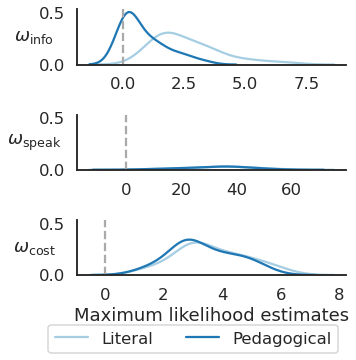

In [7]:
g = sns.FacetGrid(param_df, row='dimension', hue='model', aspect=3, height=1.75, palette='Paired', sharex=False)
g.map(sns.kdeplot, 'weight')
g.set_titles('')
g.axes.ravel()[-1].set(xlabel='Maximum likelihood estimates')
g.axes.ravel()[-1].legend(ncol=2, bbox_to_anchor=(1,-0.75))

labels=param_df.dimension.unique()
for idx,ax in enumerate(g.axes.ravel()):
    ax.set_ylabel(r'$\omega_{\mathrm{%s}}$' % labels[idx], rotation=0, va='center')
    ax.axvline(0, linestyle='--', color='#aaa')
plt.tight_layout()

plt.savefig('plots/full_model_mle.png')


Get recovered params:

In [8]:
recovered_files = gsearch('outputs', 'model_recovery', '*model-*_pref_cost.json')
recovered_files.sort()

recovered_list = []

for f in recovered_files:
    res = read_json(f)
    recovered_res = [r for r in res if r['fit_model'] == r['true_model']][0]
    [info_rec, speak_rec, cost_rec] = recovered_res['x']
    recovered_list.append((recovered_res['subject'], recovered_res['true_model'],
                          info_rec, speak_rec, cost_rec))
    
recovered_df = pd.DataFrame(recovered_list, columns=['subject', 'model', 'info', 'speak', 'cost'])
recovered_df = recovered_df.melt(id_vars=['subject', 'model'], var_name='dimension',
                                 value_name='recovered')
recovered_df['model'] = recovered_df['model'].str.extract('(literal|pragmatic)')
recovered_df['model'] = recovered_df['model'].str.title()

print(recovered_df.shape)
recovered_df.head()

(168, 4)


,subject,model,dimension,recovered
0,sub-01,Literal,info,1.558893
1,sub-01,Pragmatic,info,0.083501
2,sub-02,Literal,info,4.387055
3,sub-02,Pragmatic,info,0.322282
4,sub-04,Literal,info,3.393636


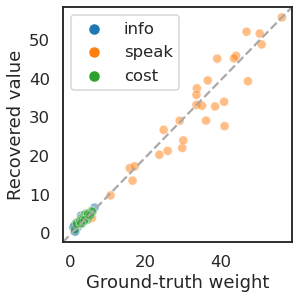

In [9]:
param_vs_recovered = param_df.merge(recovered_df)
pVr_literal = param_vs_recovered[param_vs_recovered.model == 'Literal']

f,ax=plt.subplots(figsize=(4.5,4.5))
sns.scatterplot(data=pVr_literal, x='weight', y='recovered', hue='dimension', 
                ax=ax, alpha=0.5)
ax.legend(title=None)
ax.set(xlabel='Ground-truth weight', ylabel='Recovered value')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='#aaa', linestyle='--')
plt.tight_layout()

plt.savefig('plots/param_recovery.png')

## Model evidences

Read model evidence files:

In [10]:
evidence_df = pd.read_csv('outputs/human_model_comparison/human_model_evidence_summary.csv',
                         index_col=0)
evidence_df['model'] = (
    evidence_df['model']
    .astype('category')
    .cat.reorder_categories(model_levels + ['strong'])
)

print(evidence_df.shape)
evidence_df.head()

(336, 7)


,sub,model,loglik,example,n_param,BIC,model_evidence
0,sub-01,cost,-248.913569,108,1,502.509269,-251.254634
1,sub-01,literal_cost,-241.494859,108,2,492.353980,-246.176990
2,sub-01,literal,-252.244198,108,1,509.170526,-254.585263
3,sub-01,literal_pref_cost,-213.466264,108,3,440.978922,-220.489461
4,sub-01,literal_pref,-227.600676,108,2,464.565614,-232.282807


Plot model evidences:

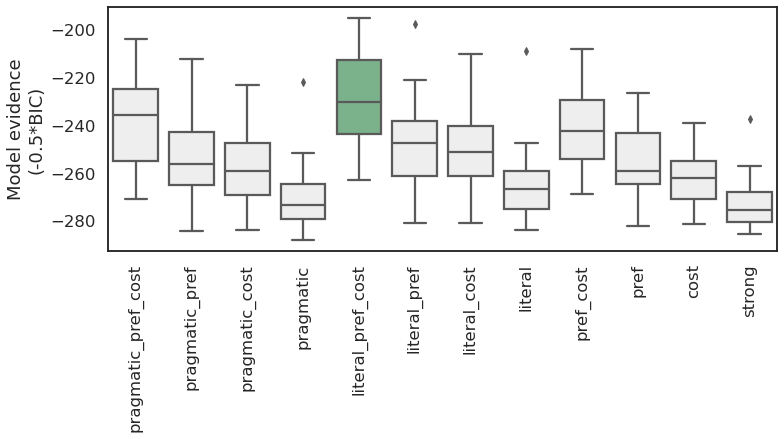

In [11]:
# Highlight winning model
winning_model = 'literal_pref_cost'
all_cats = evidence_df.model.cat.categories.tolist()
accent_idx = all_cats.index(winning_model)
pal = ['#eee' for i,e in enumerate(all_cats)]
pal[accent_idx] = '#72ba87'

fig,ax=plt.subplots(figsize=(12,4.5))
sns.boxplot(data=evidence_df, x='model', y='model_evidence', ax=ax, palette=pal)
ax.set(xlabel='', ylabel='Model evidence\n(-0.5*BIC)')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.savefig('plots/model_evidence_results.pdf', bbox_inches='tight')

## Model comparison: Which model best captures human behavior?

Read PXP file:

In [12]:
human_pxp = np.loadtxt('outputs/human_model_comparison/human_model_pxp.txt', delimiter=',')
human_labels = np.loadtxt('outputs/human_model_comparison/model_labels.txt', dtype=str)

human_df = pd.DataFrame({'model': human_labels, 'pxp': human_pxp})
human_df['model'] = human_df['model'].astype('category').cat.reorder_categories(model_levels + ['strong'])
human_df = human_df.sort_values(by='model').reset_index(drop=True)

human_df

,model,pxp
0,pragmatic_pref_cost,2.886229e-20
1,pragmatic_pref,2.886229e-20
2,pragmatic_cost,2.886229e-20
3,pragmatic,2.886229e-20
4,literal_pref_cost,1.000000e+00
5,literal_pref,2.886229e-20
6,literal_cost,2.886229e-20
7,literal,2.886229e-20
8,pref_cost,2.886229e-20
9,pref,2.886229e-20


Plot probability that a given model is the most frequently-occurring in the population (PXP):

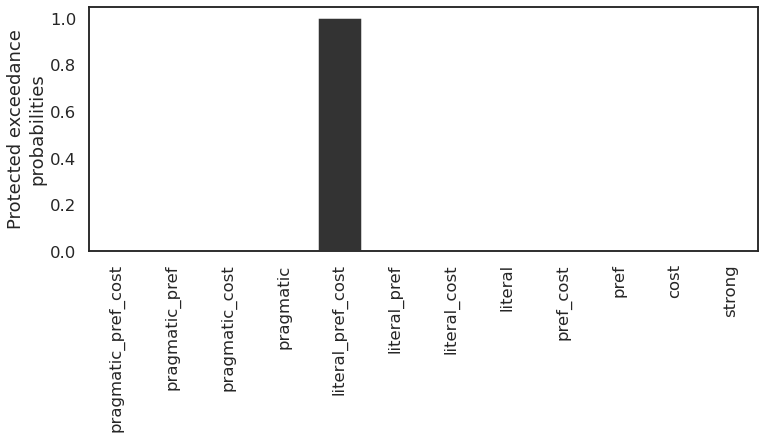

In [13]:
fig,ax=plt.subplots(figsize=(12,4.5))
sns.barplot(data=human_df, x='model', y='pxp', ax=ax, fc='#333')
ax.set(xlabel='', ylabel='Protected exceedance\nprobabilities')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.savefig('plots/model_comparison_results.pdf', bbox_inches='tight')

Assemble dataframe of posterior probabilities for each model:

In [14]:
subjects = np.loadtxt('../1_preprocessing/outputs/valid_participants.txt', dtype=int)
subjects = [f'sub-{s:02}' for s in subjects]

# Read model posteriors
posterior_df = (
    pd.read_table('outputs/human_model_comparison/human_model_posterior.txt',
                  names=model_levels+['strong'], delimiter=',')
)

# Clean up dataframe
posterior_df.index = subjects
posterior_df = posterior_df.reset_index().rename(columns={'index': 'subject'})
posterior_df = posterior_df.melt(id_vars=['subject'], var_name='model', value_name='posterior')
posterior_df['model'] = (posterior_df.model.astype('category')
                         .cat.reorder_categories(model_levels+['strong']))

posterior_df.head()

,subject,model,posterior
0,sub-01,pragmatic_pref_cost,8.701729e-16
1,sub-02,pragmatic_pref_cost,1.362372e-10
2,sub-04,pragmatic_pref_cost,2.296333e-28
3,sub-05,pragmatic_pref_cost,8.779014e-09
4,sub-06,pragmatic_pref_cost,3.127572e-13


Plot posterior probabilities:

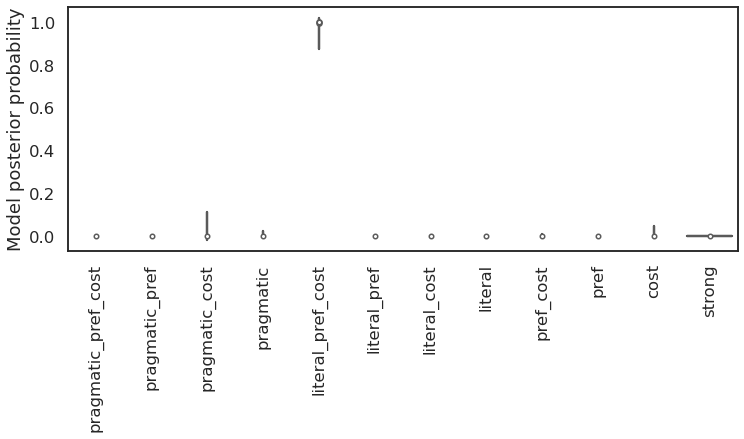

In [15]:
# Highlight winning model
winning_model = 'literal_pref_cost'
all_cats = posterior_df.model.cat.categories.tolist()
accent_idx = all_cats.index(winning_model)
pal = ['#eee' for i,e in enumerate(all_cats)]
pal[accent_idx] = '#72ba87'

fig,ax=plt.subplots(figsize=(12,4.5))
sns.violinplot(data=posterior_df, x='model', y='posterior', ax=ax, palette=pal)
ax.set(xlabel='', ylabel='Model posterior probability')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.savefig('plots/model_posterior_results.pdf', bbox_inches='tight')

## Predictive checks: How well does the winning model capture qualitative patterns in human behavior?

Helper function: Return frequency of responses as a 6x6 matrix for plotting

In [16]:
def example_matrix(group):
    freq = np.zeros(36)
    freq[group.example] = group.freq
    freq_mtx = np.reshape(freq, (6,6))
    
    return freq_mtx

Find simulation files

In [17]:
sim_files = gsearch('outputs', 'simulated_from_human', '*pref_cost.csv')
sim_files.sort()

print_list(sim_files)

Found 3 items
outputs/simulated_from_human/simulated_data_model-literal_pref_cost.csv
outputs/simulated_from_human/simulated_data_model-pragmatic_pref_cost.csv
outputs/simulated_from_human/simulated_data_model-pref_cost.csv


Wrangle simulation data

In [18]:
sim_df = pd.concat([pd.read_csv(f) for f in sim_files])

print(sim_df.shape)
sim_df.head()

(10080, 7)


,weight,niter,problem,cursor,example,subject,model
0,[1.6850824248949394 40.81649840017952 3.028553...,0,0,5,3,sub-01,literal_pref_cost
1,[1.6850824248949394 40.81649840017952 3.028553...,0,0,3,2,sub-01,literal_pref_cost
2,[1.6850824248949394 40.81649840017952 3.028553...,0,0,2,10,sub-01,literal_pref_cost
3,[1.6850824248949394 40.81649840017952 3.028553...,0,1,0,4,sub-01,literal_pref_cost
4,[1.6850824248949394 40.81649840017952 3.028553...,0,1,4,34,sub-01,literal_pref_cost


Plot average simulation results against human data

In [19]:
def predictive_check(prob_idx):
    # Mask plots using true hypothesis
    prob = teach.problems[prob_idx]
    mask = 1-np.array(prob['A'])

    # Average human responses
    prob_human = (
        teach.human_df
        [teach.human_df.problem == prob_idx]
        .copy()
        .groupby('example')
        .agg({'subject': 'count'})
        .reset_index()
        .rename(columns={'subject': 'n'})
    )
    prob_human['freq'] = prob_human.n/prob_human.n.sum()

    # Average simulated responses
    prob_sim = (
        sim_df[sim_df.problem == prob_idx]
        .copy()
        .groupby(['model', 'example'])
        .agg({'subject': 'count'})
        .reset_index()
        .rename(columns={'subject': 'n'})
    )
    prob_sim['n_total'] = prob_sim.groupby(['model']).n.transform('sum')
    prob_sim['freq'] = prob_sim.n/prob_sim.n_total

    # Plot human data
    n_models = prob_sim.model.nunique()
    fig,axes = plt.subplots(1,n_models+1, figsize=(3*(n_models+1)*1.25, 3))
    human_mtx = example_matrix(prob_human)
    sns.heatmap(human_mtx, cmap='viridis', square=True, ax=axes[0], mask=mask, lw=2, linecolor='#fff')
    axes[0].set(title='Human', xticklabels=[], yticklabels=[])

    # Plot simulated data
    ax_counter = 1
    for name, group in prob_sim.groupby('model'):
        freq_mtx = example_matrix(group)
        sns.heatmap(freq_mtx, cmap='viridis', square=True, ax=axes[ax_counter], mask=mask, lw=1, linecolor='#fff')
        axes[ax_counter].set(title='', xticklabels=[], yticklabels=[])

        ax_counter += 1

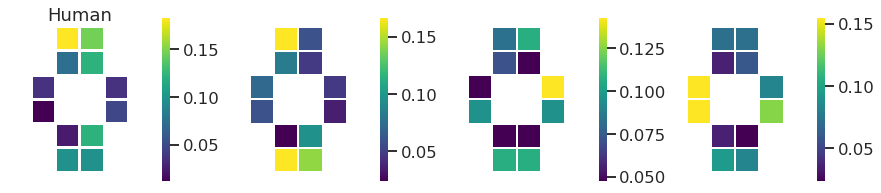

In [20]:
predictive_check(23)
plt.savefig('plots/predictive_check.png', bbox_inches='tight')

And here's a counterexample where the pedagogical model does particularly well:

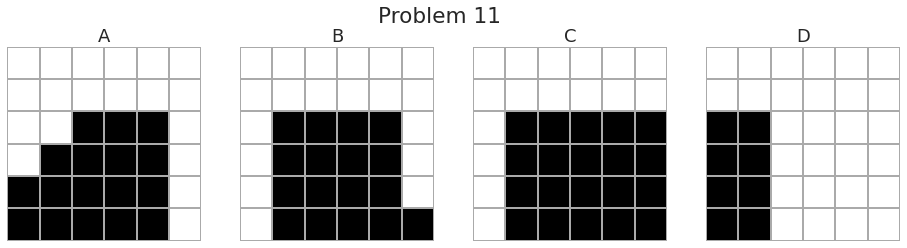

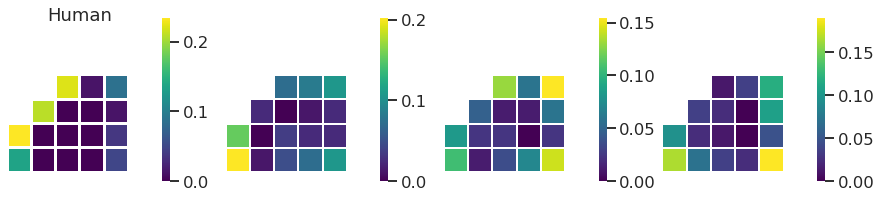

In [21]:
_ = teach.plot_problem(11)
predictive_check(11)

## Sanity check: Plot idealized model predictions

Informational value

<ipython-input-22-19e2edae1e02>:6: RuntimeWarning: divide by zero encountered in log
  info_value = np.log(pH)
/n/sw/eb/apps/centos7/Anaconda3/2020.11/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


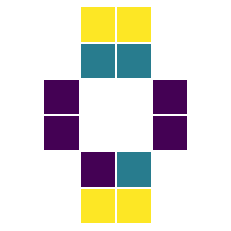

In [22]:
prob_idx = 23
prob = teach.problems[prob_idx]
prob_mask = 1-np.array(prob['A'])

pD,pH = teach.strong_sampling(prob_idx)
info_value = np.log(pH)
info_mtx = teach.sampling_matrix(info_value)

ax = sns.heatmap(info_mtx, square=True, cbar=False, cmap='viridis', lw=1, linecolor='#fff', mask=prob_mask)
ax.set(xticklabels=[], yticklabels=[])

plt.savefig('plots/info_value.png')

Edge preference:

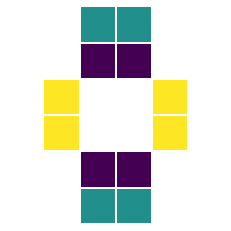

In [23]:
edge_df = teach.edge_pref(prob)
edge_mtx = teach.sampling_matrix(edge_df)
ax = sns.heatmap(edge_mtx, square=True, cbar=False, cmap='viridis', lw=1, linecolor='#fff', mask=prob_mask)
ax.set(xticklabels=[], yticklabels=[])

plt.savefig('plots/edge_pref.png')

Distance:

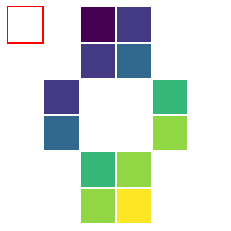

In [24]:
cost_df = teach.movement_cost(prob_idx)
cost_mtx = teach.sampling_matrix(cost_df)

ax = sns.heatmap(cost_mtx, square=True, cbar=False, cmap='viridis', lw=1, linecolor='#fff', mask=prob_mask)
ax.set(xticklabels=[], yticklabels=[])
ax.add_patch(Rectangle((0, 0), 1.0, 1.0, edgecolor='red', fill=False, lw=2))

plt.savefig('plots/distance.png')

Utility:

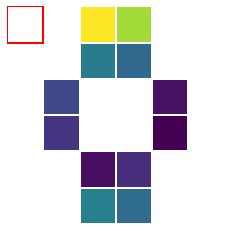

In [25]:
pD, pH = teach.utility_sampling(prob_idx, sampling_fun=teach.strong_sampling, pref_fun=teach.edge_pref)
utility_mtx = teach.sampling_matrix(pD)

ax = sns.heatmap(utility_mtx, square=True, cbar=False, cmap='viridis', lw=1, linecolor='#fff', mask=prob_mask)
ax.set(xticklabels=[], yticklabels=[])
ax.add_patch(Rectangle((0, 0), 1.0, 1.0, edgecolor='red', fill=False, lw=2))

plt.savefig('plots/utility.png')

## Check: How much variability is there in strategy selection? 

Split dataframe of model evidences into categories:

In [43]:
# helper function: name weights
def name_weights(row):
    weight_names = ['cost', 'speak']
    nonzero_weights = ['\omega_{%s}' % w for w in weight_names if row[w]]
    if len(nonzero_weights):
        weight_str = ', '.join(nonzero_weights)
        weight_label = r'$%s > 0$' % weight_str
    else: 
        weight_label = r'$\omega_{cost}, \omega_{speak} = 0$'
    
    return weight_label

evidence_cats = evidence_df.copy()

# annotate w/ weights
evidence_cats['info'] = evidence_cats.model.str.contains(r'literal|pedagogical')
evidence_cats['cost'] = evidence_cats.model.str.contains(r'cost')
evidence_cats['speak'] = evidence_cats.model.str.contains(r'pref')
evidence_cats['weight_label'] = evidence_cats.apply(name_weights, axis=1)
evidence_cats['weight_label'] = (
    evidence_cats['weight_label'].astype('category')
    .cat.reorder_categories([r'$\omega_{cost}, \omega_{speak} > 0$', r'$\omega_{cost} > 0$',
                            r'$\omega_{speak} > 0$', r'$\omega_{cost}, \omega_{speak} = 0$'])
)

# annotate w/ belief source
belief_labels = {'literal': r'$S_1$', 'pragmatic': r'$S_N$', 'belief-free': 'Belief-\nfree'}
evidence_cats['belief_source'] = evidence_cats.model.str.extract(r'(literal|pragmatic)').fillna('belief-free')
evidence_cats['belief_source'] = evidence_cats.belief_source.astype('category').cat.reorder_categories(['pragmatic', 'literal', 'belief-free'])
evidence_cats['belief_source'] = evidence_cats.belief_source.cat.rename_categories(belief_labels)

print(evidence_cats.shape)
evidence_cats.head()

(336, 12)


,sub,model,loglik,example,n_param,BIC,model_evidence,info,cost,speak,weight_label,belief_source
0,sub-01,cost,-248.913569,108,1,502.509269,-251.254634,False,True,False,$\omega_{cost} > 0$,Belief-\nfree
1,sub-01,literal_cost,-241.494859,108,2,492.353980,-246.176990,True,True,False,$\omega_{cost} > 0$,$S_1$
2,sub-01,literal,-252.244198,108,1,509.170526,-254.585263,True,False,False,"$\omega_{cost}, \omega_{speak} = 0$",$S_1$
3,sub-01,literal_pref_cost,-213.466264,108,3,440.978922,-220.489461,True,True,True,"$\omega_{cost}, \omega_{speak} > 0$",$S_1$
4,sub-01,literal_pref,-227.600676,108,2,464.565614,-232.282807,True,False,True,$\omega_{speak} > 0$,$S_1$


Plot participant-specific model evidences:

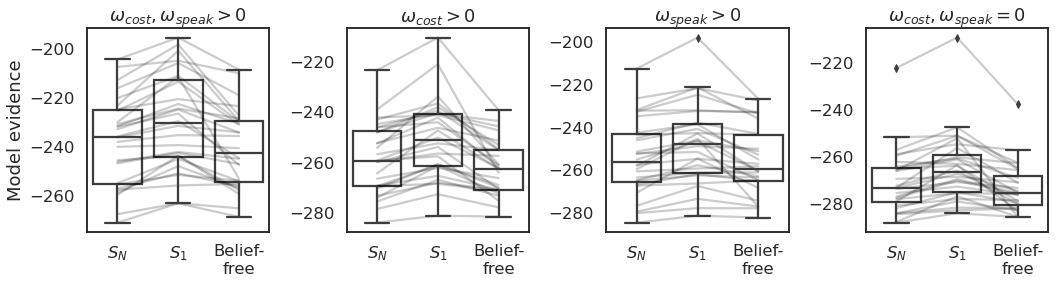

In [44]:
fig, axes = plt.subplots(1,4, figsize=(15,15/3.5))
weight_cats = evidence_cats.weight_label.cat.categories.tolist()
mono_palette = sns.color_palette(['black'], evidence_cats['sub'].nunique())

for name, group in evidence_cats.groupby('weight_label'):
    idx = weight_cats.index(name)
    sns.lineplot(data=group, x='belief_source', y='model_evidence', hue='sub', legend=False, alpha=0.2, palette=mono_palette,
                 ax=axes[idx])    
    sns.boxplot(data=group, x='belief_source', y='model_evidence', ax=axes[idx], boxprops={'facecolor': (0,0,0,0)})
    if idx > 0:
        axes[idx].set_ylabel('')
    else:
        axes[idx].set_ylabel('Model evidence')
    axes[idx].set_xlabel('')
    axes[idx].set_title(name)

plt.tight_layout()
plt.savefig('plots/participant_variability.png', bbox_inches='tight')